### This second model will be using the engineered "title_text" column, a concatenation of the title and self text of the post, as the features and logistic regression as the model. The EDA suggested there could be some promising results with this feature.

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import plot_confusion_matrix

from nltk.stem import WordNetLemmatizer, PorterStemmer

In [7]:
df=pd.read_csv('../../data/reddit_content_20220228-063053.csv')
df.head()

,Unnamed: 0,title,selftext,subreddit,created_utc
0,0,I'm working on my first UX project about reduc...,"Hi, I know this is annoying but this is my fir...",sustainability,1646023113
1,1,I’m not quite sure what to say for this but I ...,NaN,sustainability,1646021616
2,2,Self-Sustainable Communities,"Over the past few years, I've been learning a ...",sustainability,1646009146
3,3,Great Barrier Reef: New Huge Coral Found,NaN,sustainability,1645999683
4,4,Drying Hands: Blow Drying or Paper Towels,[removed],sustainability,1645997735


In [8]:
df.head()

,Unnamed: 0,title,selftext,subreddit,created_utc
0,0,I'm working on my first UX project about reduc...,"Hi, I know this is annoying but this is my fir...",sustainability,1646023113
1,1,I’m not quite sure what to say for this but I ...,NaN,sustainability,1646021616
2,2,Self-Sustainable Communities,"Over the past few years, I've been learning a ...",sustainability,1646009146
3,3,Great Barrier Reef: New Huge Coral Found,NaN,sustainability,1645999683
4,4,Drying Hands: Blow Drying or Paper Towels,[removed],sustainability,1645997735


In [9]:
df.drop(columns='Unnamed: 0', inplace=True)

df['subreddit'] = df['subreddit'].replace({'sustainability':1, 'academia':0})

df['title_text'] = df['title'] + ' ' + df['selftext'].fillna('')

X= df['title_text']
y=df['subreddit']

## Baseline

In [10]:
y.value_counts(normalize=True)

0    0.503403
1    0.496597
Name: subreddit, dtype: float64

#### This model would predict every post to be from the academia subreddit and would be correct 50.3% of the time.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [12]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('log', LogisticRegression(random_state=42))
    
])

In [13]:
df.shape

(3967, 5)

In [14]:
#code sourced from https://git.generalassemb.ly/DSIR-0124/Breakfast-Hour/blob/master/06-week/MON%20-%20S%20-%20NLP%20Practice.ipynb
def lemmatize_review(post):
    lemmatizer = WordNetLemmatizer()
    split_post = post.split(' ')
    return [lemmatizer.lemmatize(word) for word in split_post]


In [15]:
#code sourced from https://git.generalassemb.ly/DSIR-0124/Breakfast-Hour/blob/master/06-week/MON%20-%20S%20-%20NLP%20Practice.ipynb
def stem_review(post):
    p_stemmer = PorterStemmer()
    split_post = post.split(' ')
    return [p_stemmer.stem(word) for word in split_post]


In [16]:
#play with different params. trial and error
params = {
     #'cvec__stop_words': [None, 'english'],
     'cvec__max_df': [1.0, .75, .5, .25],
     'cvec__binary': [True, False],
     'cvec__tokenizer' : [None, lemmatize_review, stem_review],
     'log__penalty': ['none', 'l2',]
}

gs = GridSearchCV(pipe,
                  param_grid=params)
gs.fit(X_train, y_train)
print(gs.best_score_) # <- cross val score
gs.best_params_

0.9351260504201682


{'cvec__binary': False,
 'cvec__max_df': 1.0,
 'cvec__tokenizer': None,
 'log__penalty': 'none'}

In this grid search, I am using a pipeline consisting of count vectorizing which is counting how many times a word/phrase appears within the corpus and therefore binarizing the words of the corpus, and then running that through a logistic regression model. During the grid search, the model is ran multiple times trying out the different parameters provided for both the count vectorizer and the logistic regression model. Once the grid search is finished, I'm able to see what the best accuracy score was that grid searching produced, and the parameters the grid search found that produced that score.

This grid search in specific attempted to lemmatize or stem all of the words, however in conjuntion with trying to use stop words multiple warnings arose while grid searching as the stop words themselves were being "lemmed and/or stemmed". Then, I attempted to stem and lem the stop words by hand, and feed what should be a complete list of the stemmed and then lemmed stop words, but still saw errors. This work can be seen below. Given more time, I would further explore what stemming and lemmatizing can do for my model in conjunction with stop words.

Attempts to stem and lem with stop words:

In [17]:
#stops = list(cvec.get_stop_words()) + ['ha', 'le', 'u', 'wa']

#lemm_stop = lemmatize_review(' '.join(stops))

#stemmed_stops= stem_review(' '.join(stops))

# stemmed_lemmed_stop = stops + stemmed_stops + lemm_stop
# stemmed_lemmed_stop

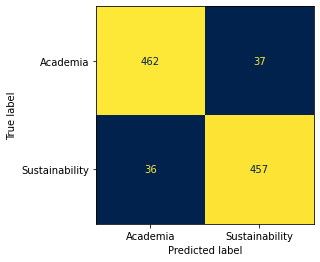

In [18]:
plot_confusion_matrix(gs, X_test, y_test, display_labels=['Academia', 'Sustainability'], cmap='cividis', colorbar=False);

This model has an accuracy score of 93.5%, but 37 false positives and 36 false negatives for a total of 73 misclassifications compared to 57 of the best model.

## Evaluation

Since this model has a accuracy score of 93.5% in comparison to a previous models score of 94.3%, no further work will be done with this model.